#  Прогнозирование заказов такси

Наш заказчик - служба такси - просит нас построить модель для прогнозирования количества заказов такси на следующий час.

В нашем распоряжении исторические данные о заказах такси в аэропортах. 

In [1]:
!pip install lightgbm -q

# Импортируем основные библиотеки для работы
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import sys

# Импортируем модели, метрики, вспомогательные инструменты и функции
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor

# warnings.filterwarnings("ignore", category=FutureWarning) 

# if not sys.warnoptions:
#     warnings.simplefilter("ignore")
#     os.environ["PYTHONWARNINGS"] = "ignore"

pd.set_option('display.max_columns', None)

random_state = 42

n_cpus = os.cpu_count()
n_jobs = n_cpus - 1

## Подготовка

### Изучение основной информации о датасете

Откроем файл и сохраним его в переменной `df`, получим основную информацию с помощью метода .info() и построим гистограммы для всех признаков датасета.

In [2]:
try:
    df = pd.read_csv('taxi.csv')
except:
    df = pd.read_csv('/datasets/taxi.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


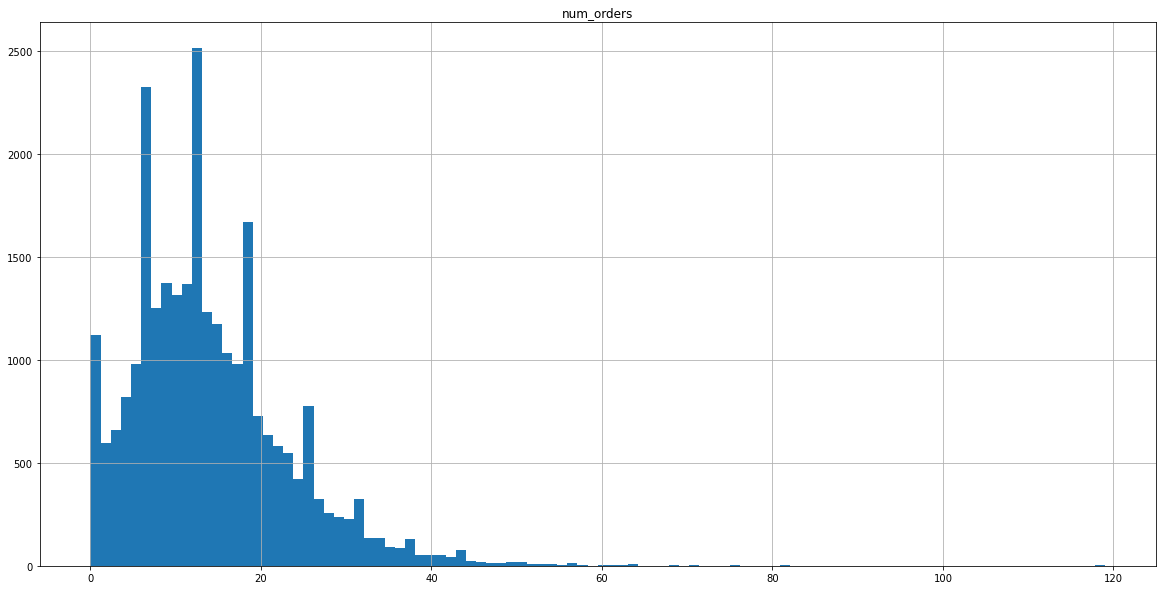

In [5]:
df.hist(figsize=(20, 10), bins=100)
plt.show()

In [6]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


---
**Вывод:** изучив основную информацию о датасете, можно утверждать, что
- на всякий случай имеет смысл проверить данные на дубликаты;
- необходимо будет перевести столбец "datetime" из типа object в datetime и принять его за индекс - для нашего удобства; затем - ресемплировать данные по 1 часу;
- в данных отсутствуют пропуски;
- в данных присутствуют экстремальные значения, например, количество заказов = 119; взглянем подробнее на них.

### Поиск дубликатов

Проведём поиск явных дубликатов. Удалим их.

In [7]:
df.duplicated().sum()

0

In [8]:
df.duplicated(subset=['datetime']).sum()

0

Дубликатов нет.

### Обработка столбца datetime и ресемплирование

Переведём столбец "datetime" в нужный нам формат.

In [9]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Примем столбец "datetime" за индекс.

In [11]:
df = df.set_index('datetime')

In [12]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Ресемплируем данные по часу с суммированием.

In [13]:
df = df.resample('1H').sum()

In [14]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Обработка столбца "datetime" и ресемплирование проведены.

### Анализ экстремальных значений

Снова взглянем на распределение заказов.

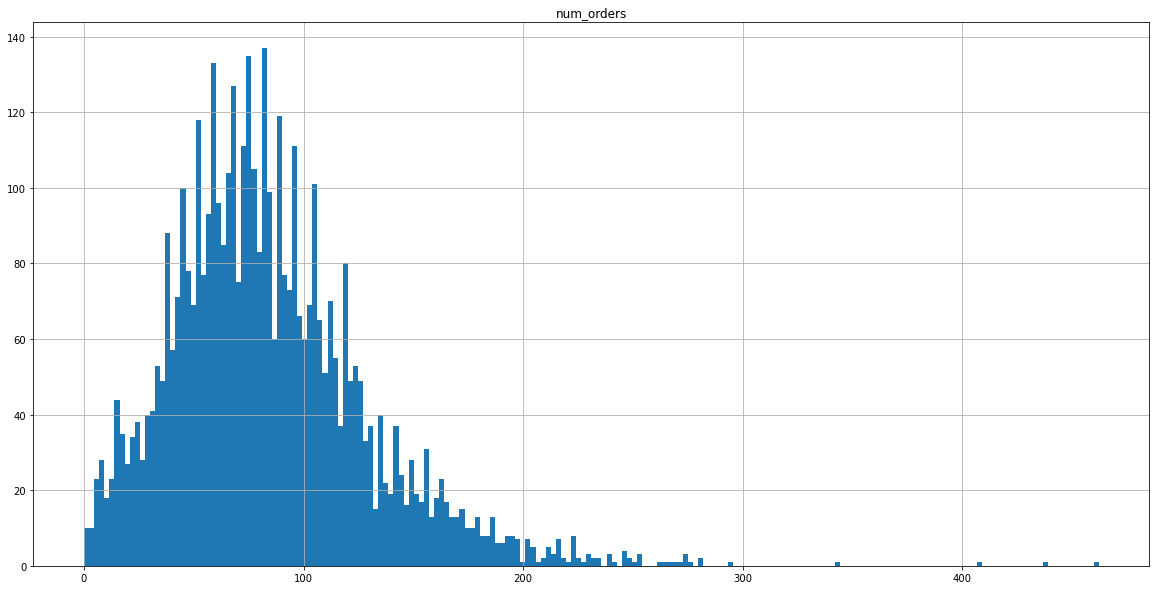

In [15]:
df.hist(figsize=(20, 10), bins=200)
plt.show()

Посмотрим на строки, где количество заказов > 300.

In [16]:
df[df['num_orders'] > 300].head(10)

,num_orders
datetime,
2018-08-13 02:00:00,437
2018-08-20 02:00:00,462
2018-08-27 02:00:00,408
2018-08-30 17:00:00,342


Экстремальные значения пришлись на 2 часа ночи понедельников 3х недель подряд (ночь с выходных на рабочие) и на час пик в четверг. Что ж, такое возможно; не стоит отбрасывать данные строки.

---
**Вывод:** завершив этап подготовки данных, мы
- проверили данные на дубликаты - их нет;
- перевели столбец "datetime" из типа object в datetime и приняли его за индекс; затем - ресемплировали данные по 1 часу с суммированием;
- изучили экстремальные значения и приняли решение не трогать их.

## Анализ

В данном разделе мы изучим тренды, сезонные составляющие и остатки в зависимости от ресемплирования (на 1 час и на 1 день); кроме того, мы примем решение какие именно дополнительные признаки создавать для нашего датасета.

### Декомпозиция на составляющие

Ресемплируем данные по 1 дню в отдельный датасет; декомпозируем данные на тренд, сезонность и остатки.

In [17]:
df_1D = df.resample('1D').sum()

decomposed_1H = seasonal_decompose(df)
decomposed_1D = seasonal_decompose(df_1D)

Построим графики тренда, сезонности и остатков для данных, ресемплированных по 1 часу.

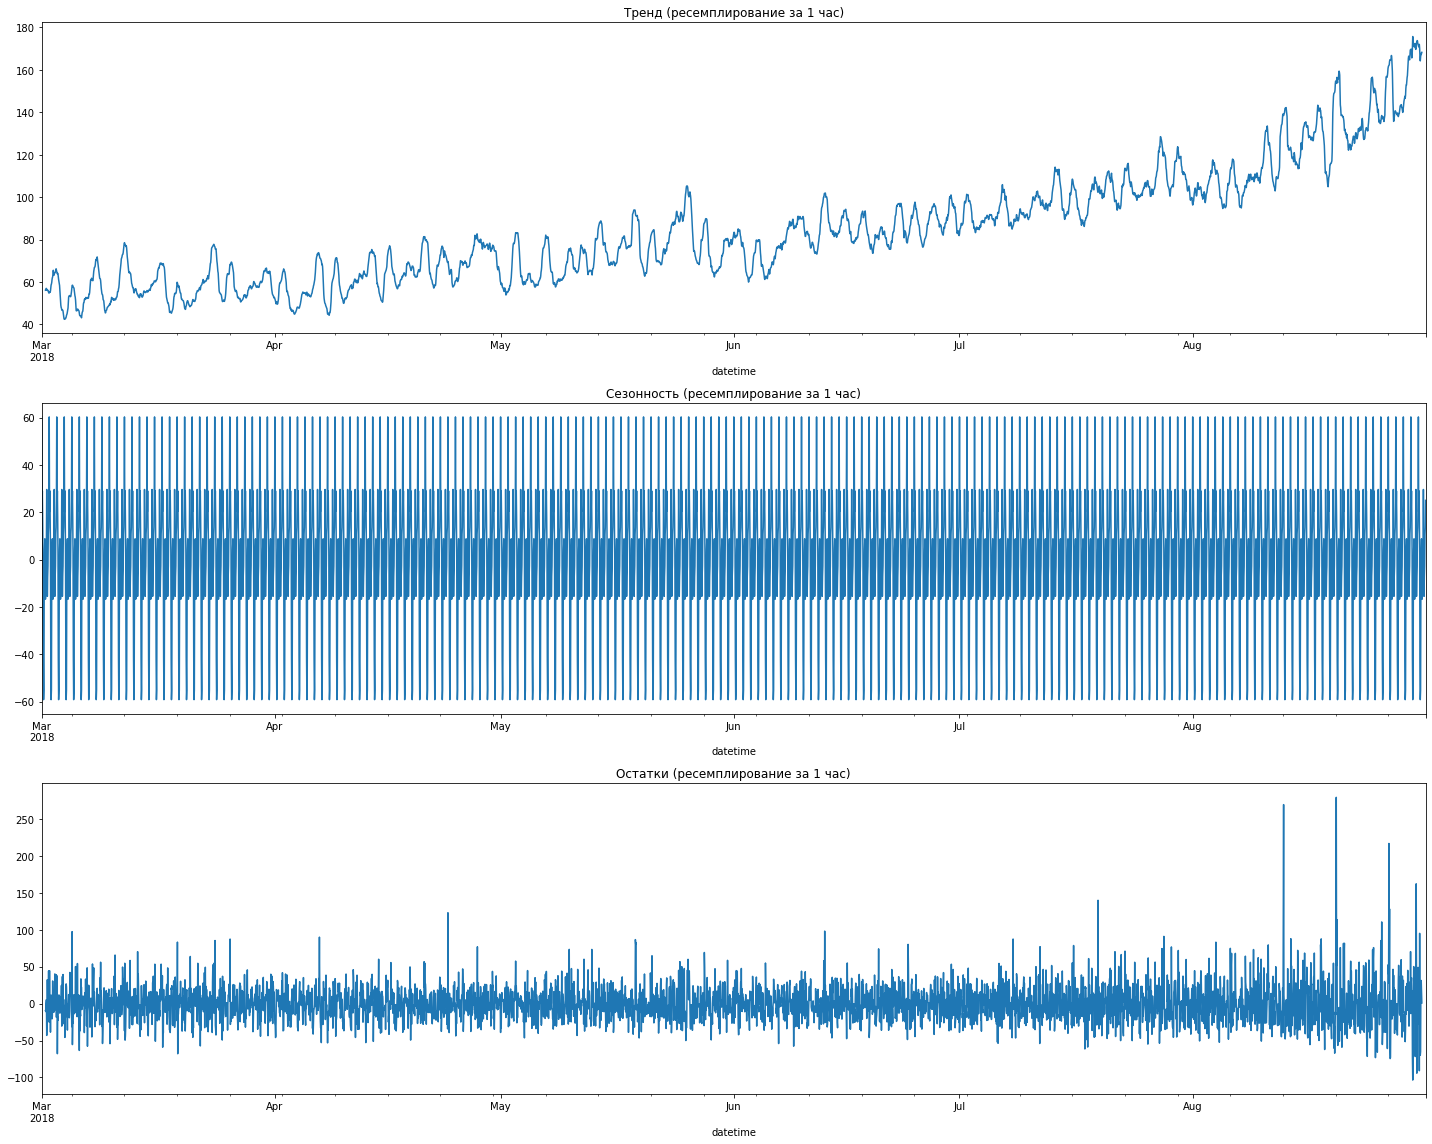

In [18]:
plt.figure(figsize=(20, 16))
plt.subplot(311)
decomposed_1H.trend.plot(ax=plt.gca())
plt.title('Тренд (ресемплирование за 1 час)')
plt.subplot(312)
decomposed_1H.seasonal.plot(ax=plt.gca())
plt.title('Сезонность (ресемплирование за 1 час)')
plt.subplot(313)
decomposed_1H.resid.plot(ax=plt.gca())
plt.title('Остатки (ресемплирование за 1 час)')
plt.tight_layout()

Тренд - на явный месячный рост. По данным графикам плохо различима сезонность. Возьмём срез данных за 1 неделю.

In [19]:
df_1H_1week = df['2018-03-05 00':'2018-03-12 00'] # 2018-03-05 - понедельник, а 2018-03-12 - понедельник

decomposed_1H_1week = seasonal_decompose(df_1H_1week)

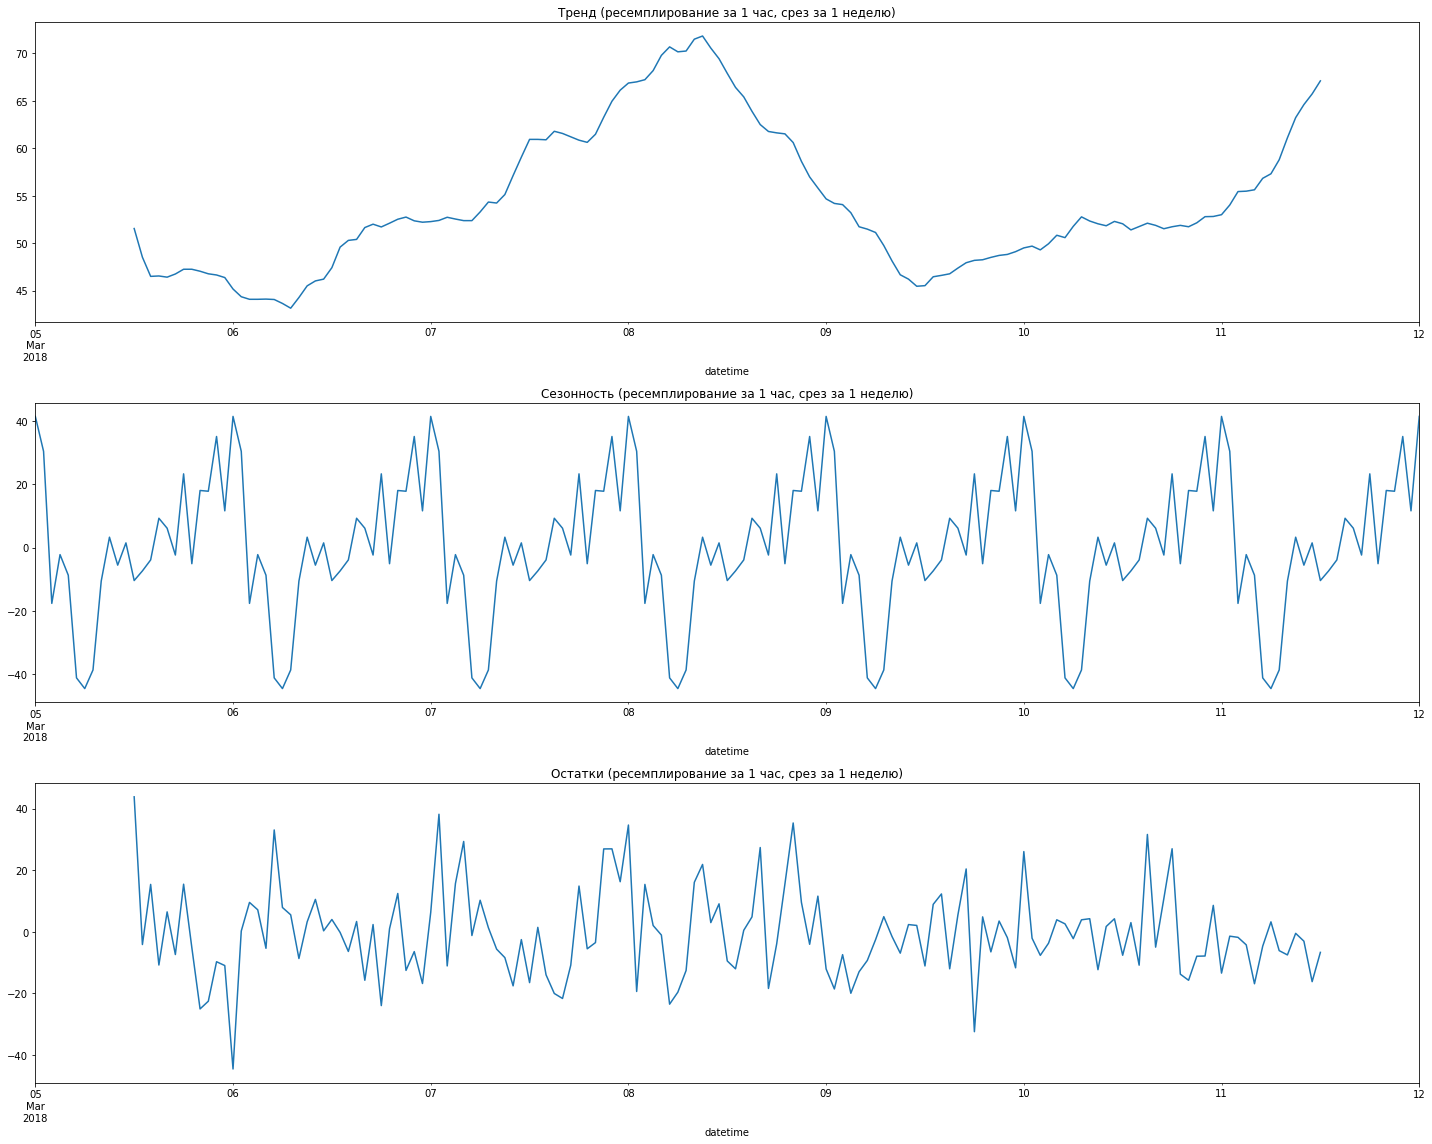

In [20]:
plt.figure(figsize=(20, 16))
plt.subplot(311)
decomposed_1H_1week.trend.plot(ax=plt.gca())
plt.title('Тренд (ресемплирование за 1 час, срез за 1 неделю)')
plt.subplot(312)
decomposed_1H_1week.seasonal.plot(ax=plt.gca())
plt.title('Сезонность (ресемплирование за 1 час, срез за 1 неделю)')
plt.subplot(313)
decomposed_1H_1week.resid.plot(ax=plt.gca())
plt.title('Остатки (ресемплирование за 1 час, срез за 1 неделю)')
plt.tight_layout()

Как мы видим, количество заказов зависит от времени дня - это можно увидеть по сезонной составляющей за 1 неделю. Давайте подтвердим мысль, что количество заказов зависит ещё и от дня недели.

Построим графики тренда, сезонности и остатков для данных, ресемплированных по 1 дню.

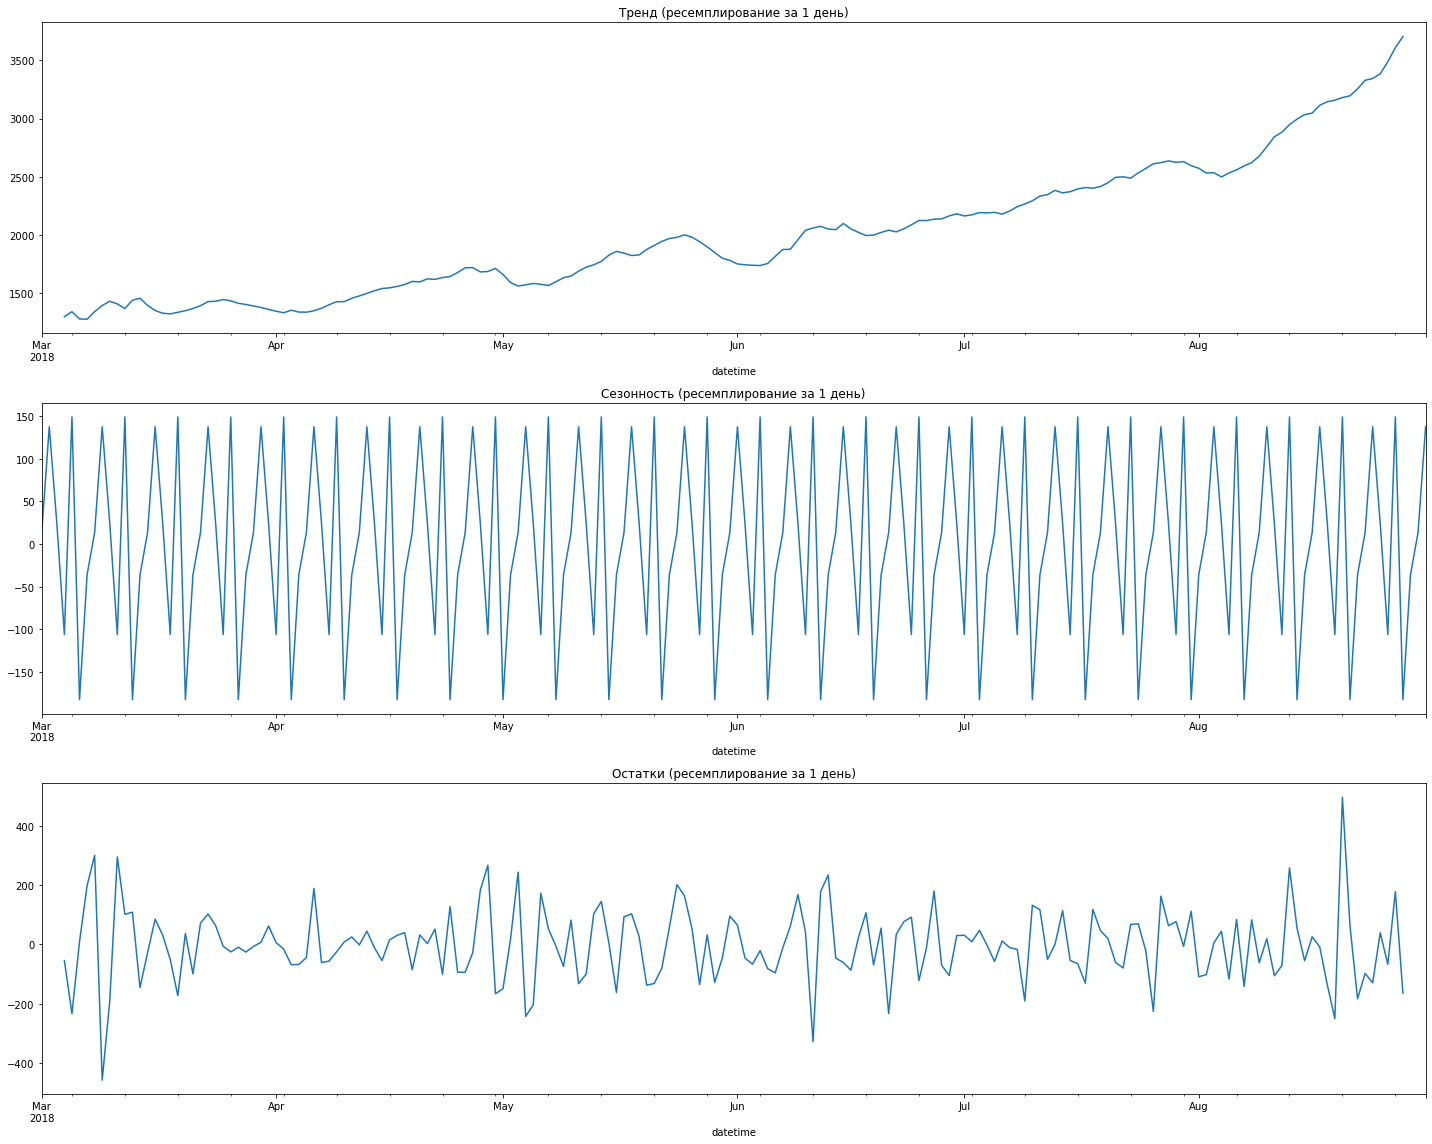

In [21]:
plt.figure(figsize=(20, 16))
plt.subplot(311)
decomposed_1D.trend.plot(ax=plt.gca())
plt.title('Тренд (ресемплирование за 1 день)')
plt.subplot(312)
decomposed_1D.seasonal.plot(ax=plt.gca())
plt.title('Сезонность (ресемплирование за 1 день)')
plt.subplot(313)
decomposed_1D.resid.plot(ax=plt.gca())
plt.title('Остатки (ресемплирование за 1 день)')
plt.tight_layout()

Тренд - на месячный рост. По данным графикам различима сезонность, но мы возьмём срез данных за 1 месяц - для наглядности.

In [22]:
df_1D_1week = df_1D['2018-03-01':'2018-04-03'] # 2018-03-05 - понедельник, а 2018-04-03 - понедельник

decomposed_1D_1month = seasonal_decompose(df_1D_1week)

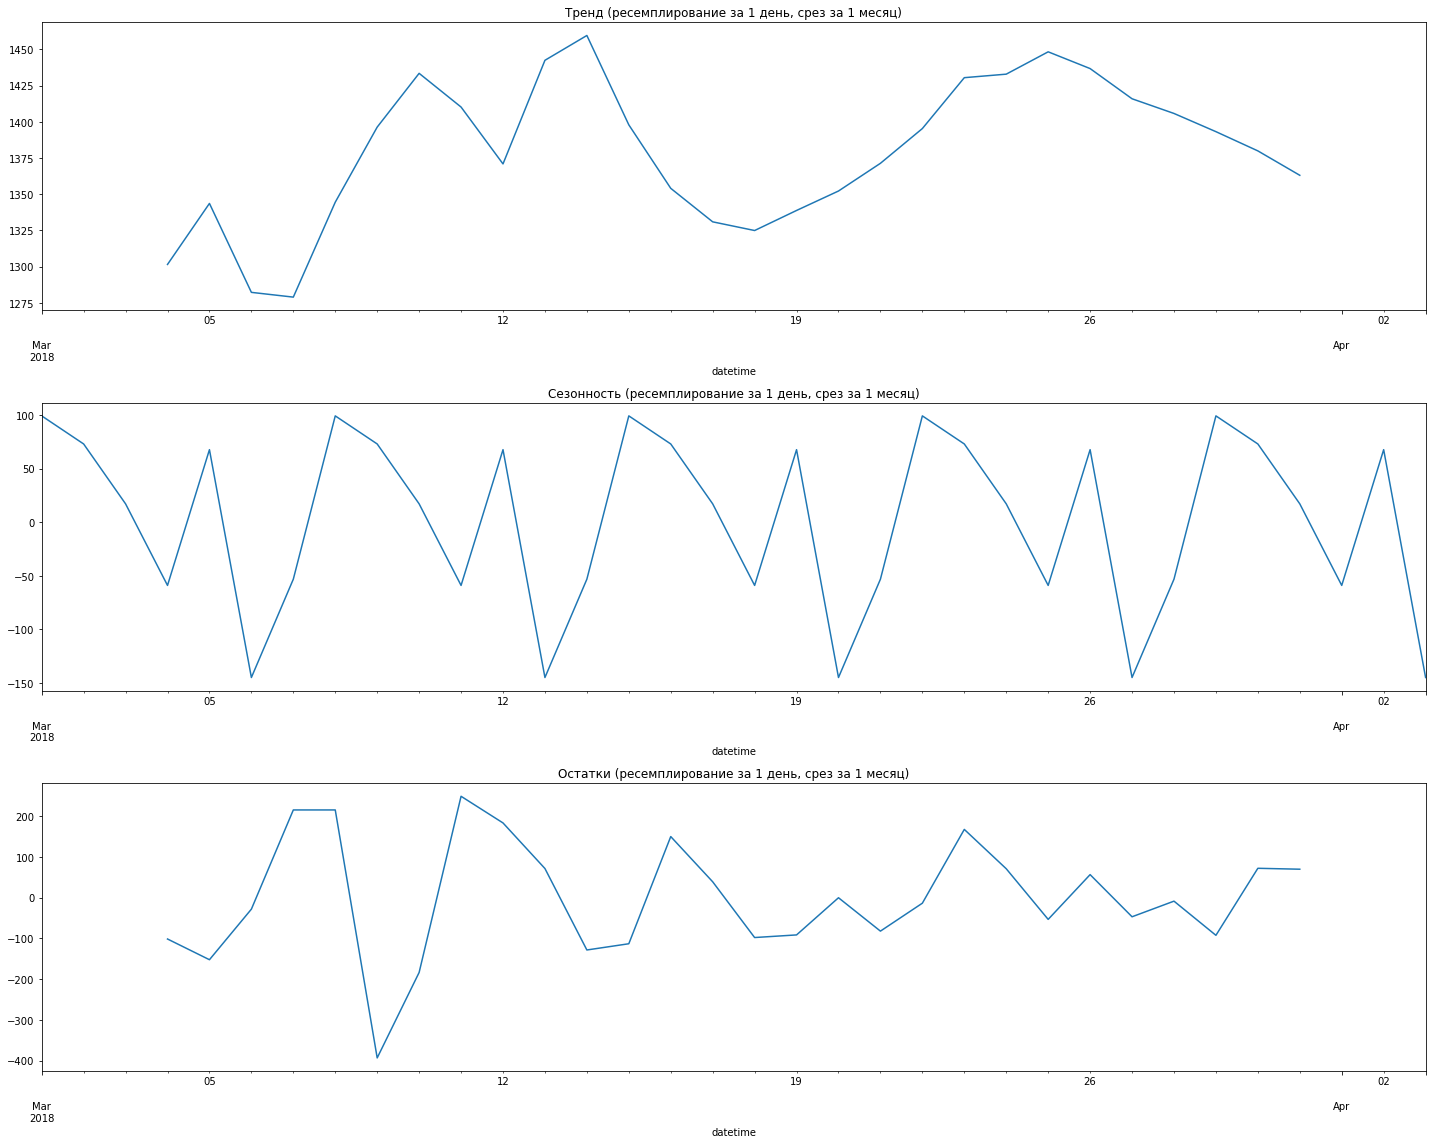

In [23]:
plt.figure(figsize=(20, 16))
plt.subplot(311)
decomposed_1D_1month.trend.plot(ax=plt.gca())
plt.title('Тренд (ресемплирование за 1 день, срез за 1 месяц)')
plt.subplot(312)
decomposed_1D_1month.seasonal.plot(ax=plt.gca())
plt.title('Сезонность (ресемплирование за 1 день, срез за 1 месяц)')
plt.subplot(313)
decomposed_1D_1month.resid.plot(ax=plt.gca())
plt.title('Остатки (ресемплирование за 1 день, срез за 1 месяц)')
plt.tight_layout()

На графике сезонности видно, что количество заказов зависит ещё и от дня недели.

Если бы у нас были данные как минимум за 2 года, то мы смогли бы проверить предположение, что количество заказов зависит ещё и от месяца.

---
Итак, как мы изучили, данные характеризуются следующими составляющими:
- тренд колеблющийся, но явно увеличивающийся в масштабе месяцев;
- четкая сезонность данных в зависимости от времени дня и дня недели;
- не можем подтвердить сезонность в зависимости от месяца из-за недостатка данных (датасет представлен данными за март-август 2018 года; нужны данные как минимум за 2 года).

### Создание дополнительных признаков

Создадим новые переменные:
- час;
- день недели;
- сдвиги количества заказов за 24 часа назад (всего 24 признака);
- скользящее среднее количества заказов за 24 часа со сдвигом в 1 час (чтобы избежать утечки данных).

Они помогут моделям предсказывать необходимый целевой признак, т.е. количество заказов на следующий час.

In [24]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['dayofweek'] = data_new.index.dayofweek # день недели
    data_new['hour'] = data_new.index.hour # час
    
    for lag in range(1, max_lag + 1): # сдвиги количества заказов
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

        # скользящее среднее количества заказов
    data_new['rolling_mean'] = data_new['num_orders'].rolling(rolling_mean_size).mean().shift(1)
    return data_new

Создадим новый датасет:

In [25]:
df_new_features = make_features(df, 24, 24)

In [26]:
df_new_features = df_new_features.dropna()

In [27]:
df_new_features.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,120,4,1,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,75,4,2,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,64,4,3,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,20,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333


Датасет с новыми признаками готов.

### Разбиение данных на выборки

Разобьём данные на обучающую, валидационную и тестовую выборку в соотношении 8:1:1.

In [28]:
X_train, X_temp, y_train, y_temp = train_test_split(
    df_new_features.drop(['num_orders'], axis=1), # признаки
    df_new_features['num_orders'], # таргет
    test_size=0.2,
    shuffle=False
)

X_train.shape, X_temp.shape

((3513, 27), (879, 27))

In [29]:
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, # признаки
    y_temp, # таргет
    test_size=0.5,
    shuffle=False
)

X_valid.shape, X_test.shape

((439, 27), (440, 27))

Выборки готовы.

---
**Вывод:** завершив этап анализа данных, мы
- декомпозировали данные на составляющие и изучили их:
    - тренд колеблющийся, но явно увеличивающийся в масштабе месяцев;
    - четкая сезонность данных в зависимости от времени дня и дня недели;
    - не можем подтвердить сезонность в зависимости от месяца из-за недостатка данных (датасет представлен данными за март-август 2018 года; нужны данные как минимум за 2 года);
    
- создали новые переменные:
    - час;
    - день недели;
    - сдвиги количества заказов за 24 часа назад (всего 24 признака);
    - скользящее среднее количества заказов за 24 часа со сдвигом в 1 час (чтобы избежать утечки данных);
    
- разбили данные на обучающую, валидационную и тестовую выборку в соотношении 8:1:1.

## Обучение

Мы обучим три модели:
- линейную регрессию с L2-регуляризацией;
- градиентный бустинг LGBM;
- метод опорных векторов (с линейным ядром).

Поскольку мы моделируем временные ряды, нам нельзя перемешивать данные, поэтому использовать кросс-валидацию и GridSearchCV нельзя. Будем подбирать гиперпараметры в циклах.

In [30]:
# Для сводной таблицы
model = []
score = []

### Ridge-регрессия

In [31]:
pipe_ridge_best = None # Лучшие показатели
solver_best = None
alpha_best = None
best_score_ridge = 1e10

for solver in ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']: # Перебор гиперпараметров в цикле
    for alpha in [1,5,10,20]:

        pipe_ridge = Pipeline([ 
            # == Стандартизация ====
            ('standard_scaler', StandardScaler()),

            # == Модель линейной регрессии с L2-регуляризацией ====
            ('model', Ridge(random_state=random_state, alpha=alpha, solver=solver))
        ])

        pipe_ridge.fit(X_train, y_train) # Обучаем модель

        predictions_valid_ridge = pipe_ridge.predict(X_valid) # Проверяем на валидационной выборке
        rmse_valid_ridge = mean_squared_error(y_valid, predictions_valid_ridge, squared=False)
        
        if best_score_ridge > rmse_valid_ridge: # Запоминаем лучшие показатели
            best_score_ridge = rmse_valid_ridge
            solver_best = solver
            alpha_best = alpha
            pipe_ridge_best = pipe_ridge

print('Best RMSE validation score:', best_score_ridge)
print('Гиперпараметры:')
pipe_ridge_best

Best RMSE validation score: 34.37765856167851
Гиперпараметры:


Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model', Ridge(alpha=1, random_state=42, solver='sag'))])

In [32]:
model.append('Ridge regression')
score.append(best_score_ridge)

### Градиентный бустинг

In [33]:
pipe_lgbm_best = None
max_depth_best = None
n_estimators_best = None
best_score_lgbm = 1e10

for max_depth in [4, 5, 6]:
    for n_estimators in [70, 100, 150]:

        pipe_lgbm = Pipeline([
            # == Стандартизация ====
            ('standard_scaler', StandardScaler()),

            # == Модель градиентного бустинга LGBM ====
            ('model', LGBMRegressor(random_state=random_state, max_depth=max_depth, n_estimators=n_estimators))
        ])

        pipe_lgbm.fit(X_train, y_train)

        predictions_valid_lgbm = pipe_lgbm.predict(X_valid)
        rmse_valid_lgbm = mean_squared_error(y_valid, predictions_valid_lgbm, squared=False)
        
        if best_score_lgbm > rmse_valid_lgbm:
            best_score_lgbm = rmse_valid_lgbm
            max_depth_best = max_depth
            n_estimators_best = n_estimators
            pipe_lgbm_best = pipe_lgbm
            
print('Best RMSE validation score:', best_score_lgbm)
print('Гиперпараметры:')
pipe_lgbm_best

Best RMSE validation score: 31.407366069470815
Гиперпараметры:


Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model',
                 LGBMRegressor(max_depth=5, n_estimators=150,
                               random_state=42))])

In [34]:
model.append('LGBM')
score.append(best_score_lgbm)

### Метод опорных векторов

In [35]:
pipe_svr_best = None
kernel_best = None
C_best = None
best_score_svr = 1e10

for kernel in ['poly', 'linear', 'rbf', 'sigmoid']:
    for C in [0.5, 1, 2, 5]:

        pipe_svr = Pipeline([
            # == Стандартизация ====
            ('standard_scaler', StandardScaler()),

            # == Модель метода опорных векторов ====
            ('model', SVR(kernel=kernel, C=C))
        ])

        pipe_svr.fit(X_train, y_train)

        predictions_valid_svr = pipe_svr.predict(X_valid)
        rmse_valid_svr = mean_squared_error(y_valid, predictions_valid_svr, squared=False)
        
        if best_score_svr > rmse_valid_svr:
            best_score_svr = rmse_valid_svr
            kernel_best = kernel
            C_best = C
            pipe_svr_best = pipe_svr
            
print('Best RMSE validation score:', best_score_svr)
print('Гиперпараметры:')
pipe_svr_best

Best RMSE validation score: 35.21135599098456
Гиперпараметры:


Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model', SVR(C=2, kernel='linear'))])

In [36]:
model.append('Support vector regression')
score.append(best_score_svr)

---
**Вывод:** завершив этап обучения, мы
- обучили три модели:
    - ridge-регрессию;
    - градиентный бустинг LGBM;
    - support vector regression;
- собрали необходимую статистику по обученным моделям.

## Тестирование

### Выбор моделей

Взглянем на сводную таблицу результатов обучения моделей и проверки на валидационной выборке:

In [37]:
models_dict = {'model' : model, 'score' : score}
models_results = pd.DataFrame(models_dict)
models_results

,model,score
0,Ridge regression,34.377659
1,LGBM,31.407366
2,Support vector regression,35.211356


Лучший результат показал градиентный бустинг, но мы знаем, что "деревянные" модели плохо экстраполируются, поэтому бустинг нам не подойдёт. Выберем второй лучший результат - ridge-регрессию. Она неплохо справилась, к тому же отлично экстраполируется.

### Обучение лучшей модели на конкатенированной выборке

Поскольку мы выбрали лучшую модель, дообучим её на полной выборке: обучающей+валидационной. Это должно улучшить наш score на тестовой выборке.

In [38]:
X_train_and_valid = pd.concat([X_train, X_valid], axis=0)
y_train_and_valid = pd.concat([y_train, y_valid], axis=0)

X_train_and_valid.shape, y_train_and_valid.shape

((3952, 27), (3952,))

In [39]:
pipe_ridge_test = Pipeline([
    # == Стандартизация ====
    ('standard_scaler', StandardScaler()),
    
    # == Модель линейной регрессии с L2-регуляризацией ====
    ('model', Ridge(random_state=random_state, alpha=alpha_best, solver=solver_best))
])

pipe_ridge_test.fit(X_train_and_valid, y_train_and_valid)

Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model', Ridge(alpha=1, random_state=42, solver='sag'))])

### Расчёт RMSE на тестовой выборке

Посмотрим, какой score у нашей лучшей модели на тестовой выборке.

In [40]:
predictions_test_concat = pipe_ridge_test.predict(X_test)
rmse_test_concat = mean_squared_error(y_test, predictions_test_concat, squared=False)
print('RMSE на тестовой выборке у ridge-регрессии, обученной на конкатенированной выборке:', rmse_test_concat)

RMSE на тестовой выборке у ridge-регрессии, обученной на конкатенированной выборке: 45.22265818606463


Оценим, сколько бы мы получили, если бы не учили регрессию на дополненной выборке:

In [41]:
predictions_test_train = pipe_ridge_best.predict(X_test)
rmse_test_train = mean_squared_error(y_test, predictions_test_train, squared=False)
print('RMSE на тестовой выборке у ridge-регрессии, обученной только на обучающей выборке:', rmse_test_train)

RMSE на тестовой выборке у ridge-регрессии, обученной только на обучающей выборке: 45.66274219254644


Что ж, небольшой прирост есть.

---
Построим графики рассеяния, чтобы оценить величины ошибок между предсказаниями и целевыми признаками и точность наших моделей; понять, за счёт чего у нас образуется такая ошибка.

In [42]:
dict_target_predictions = {
    'target' : y_test,
    'predictions' : predictions_test_concat,
    'error' : y_test - predictions_test_concat
}

df_target_predictions = pd.DataFrame(dict_target_predictions)

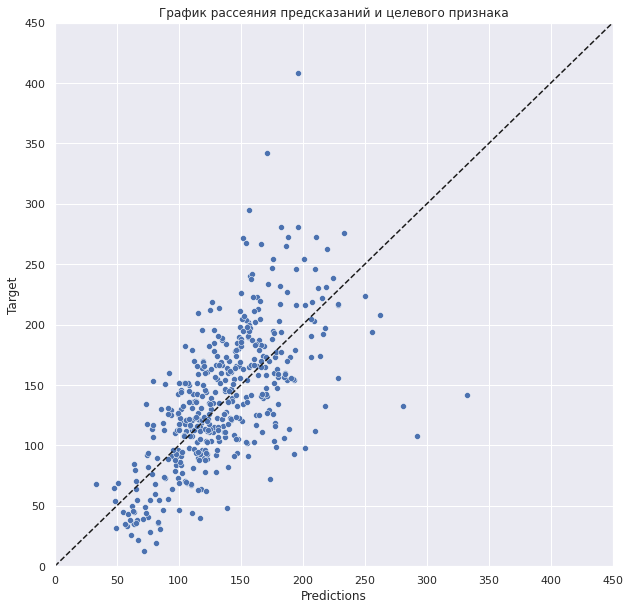

In [43]:
sns.set(rc={'figure.figsize':(10,10)})
g = sns.scatterplot(data=df_target_predictions, x='predictions', y='target')

g.plot([0, 450], [0, 450], ls="--", c=".1")
g.set(xlim=(0, 450), ylim=(0, 450))

plt.title('График рассеяния предсказаний и целевого признака')
plt.xlabel('Predictions')
plt.ylabel('Target')

plt.show()

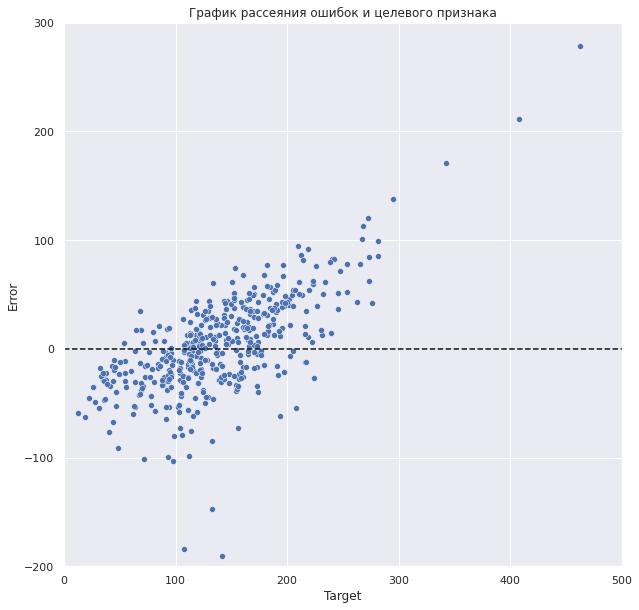

In [44]:
g = sns.scatterplot(data=df_target_predictions, x='target', y='error')

g.plot([0, 500], [0, 0], ls="--", c=".05")
g.set(xlim=(0, 500), ylim=(-200, 300))

plt.title('График рассеяния ошибок и целевого признака')
plt.xlabel('Target')
plt.ylabel('Error')

plt.show()

Как мы видим, наша ошибка складывается за счёт:
- слишком больших предсказаний для целевого признака с низким значением;
- слишком маленьких предсказаний для целевого признака с высоким значением.

В целом, у нашей модели не очень большой разброс (variance), но большое смещение (bias), что характерно для простых моделей вроде линейной регрессии.

--- 
Визуализируем нашу тестовую выборку и предсказания на одном графике - для наглядности.

In [45]:
# predictions = pd.DataFrame(predictions_test_concat, index=y_test.index)

plot_dict = {'Тестовая выборка' : y_test, 'Предсказания' : predictions_test_concat}

plot_data = pd.DataFrame(plot_dict)

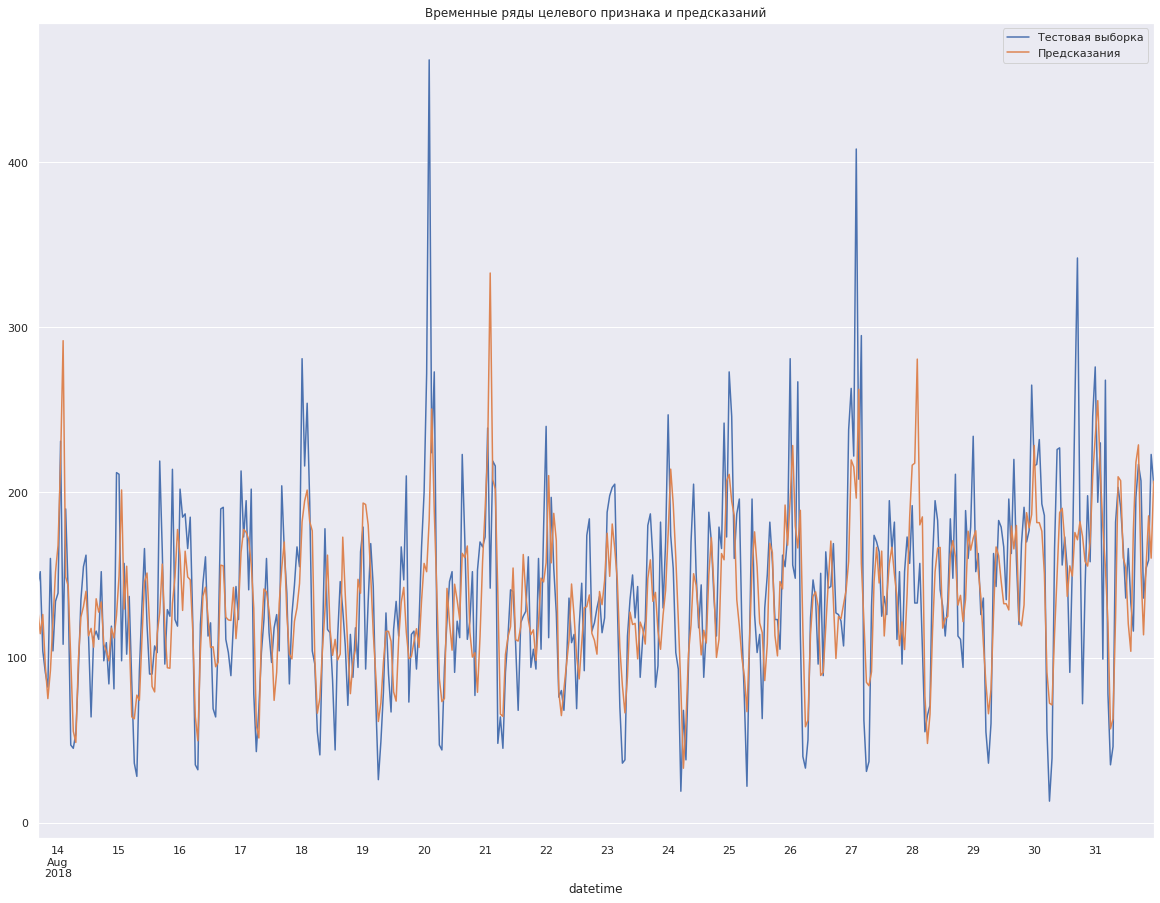

In [46]:
plot_data.plot(figsize=(20,15))
plt.title('Временные ряды целевого признака и предсказаний')
plt.show()

Как мы видим, временной ряд предсказаний хорошо накладывается на ряд целевого признака, но наша модель плохо предсказывает пиковые значения и vice versa кое-где прогнозирует слишком большие значения.

### Проверка модели на адекватность

Проверим нашу модель на адекватность. Построим модель пустышку, всегда предсказывающую среднее значение:

In [47]:
dummy_mean = DummyRegressor(strategy='mean')
dummy_mean.fit(X_train, y_train)
dummy_mean_predictions = dummy_mean.predict(X_test)
rmse_test_dummy_mean = mean_squared_error(y_test, dummy_mean_predictions, squared=False)
print('RMSE модели-пустышки, предсказывающей среднее:', rmse_test_dummy_mean)

RMSE модели-пустышки, предсказывающей среднее: 87.63978988361437


И построим модель-пустышку, всегда предсказывающую предыдущее значение:

In [48]:
last_value_predictions = y_test.shift(1)
last_value_predictions.iloc[0] = y_valid.iloc[-1]

rmse_test_last_value = mean_squared_error(y_test, last_value_predictions, squared=False)
print('RMSE модели-пустышки, предсказывающей предыдущее значение:', rmse_test_last_value)

RMSE модели-пустышки, предсказывающей предыдущее значение: 58.881776776551476


Результат нашей лучшей модели гораздо меньше моделей-пустышек, наши модели адекватны!

---
**Вывод:** завершив этап тестирования, мы
- выбрали лучшую модель - линейную регрессию, поскольку она показала второй лучший результат в 34 RMSE на валидационной выборке и хорошо экстраполируется, что нам крайне важно;
- обучили лучшую модель линейной регресии на конкатенированной выборке (обучающая + валидационная);
- **рассчитали RMSE на тестовой выборке для ridge-регрессии - 45**;
- изучили, за счёт чего складывается ошибка нашей модели:
    - слишком больших предсказаний для целевого признака с низким значением;
    - слишком маленьких предсказаний для целевого признака с высоким значением.
    - в целом, у нашей модели не очень большой разброс (variance), но большое смещение (bias), что характерно для простых моделей вроде линейной регрессии;
- проверили нашу модель на адекватность - она адекватна, RMSE моделей-пустышек 88 и 59.

## Общий вывод

Отвечая сразу на главный вопрос проекта: мы предлагаем использовать обученную нами модель ridge-регрессии для предсказания количества заказов на следующий час. **RMSE модели на тестовой выборке - 45.** Кроме того, она хорошо экстраполируется на будущие данные.

В целом, в ходе проекта:

- завершив этап подготовки данных, мы
    - проверили данные на дубликаты - их нет;
    - перевели столбец "datetime" из типа object в datetime и приняли его за индекс; затем - ресемплировали данные по 1 часу с суммированием;
    - изучили экстремальные значения и приняли решение не трогать их.
    
    
- завершив этап анализа данных, мы
    - декомпозировали данные на составляющие и изучили их:
        - тренд колеблющийся, но явно увеличивающийся в масштабе месяцев;
        - четкая сезонность данных в зависимости от времени дня и дня недели;
        - не можем подтвердить сезонность в зависимости от месяца из-за недостатка данных (датасет представлен данными за март-август 2018 года; нужны данные как минимум за 2 года);
    
    - создали новые переменные:
        - час;
        - день недели;
        - сдвиги количества заказов за 24 часа назад (всего 24 признака);
        - скользящее среднее количества заказов за 24 часа со сдвигом в 1 час (чтобы избежать утечки данных);
    
    - разбили данные на обучающую, валидационную и тестовую выборку в соотношении 8:1:1.
    
    
- завершив этап обучения, мы
    - обучили три модели:
        - ridge-регрессию;
        - градиентный бустинг LGBM;
        - support vector regression;
    - собрали необходимую статистику по обученным моделям.
    
    
- завершив этап тестирования, мы
    - выбрали лучшую модель - линейную регрессию, поскольку она показала второй лучший результат в 34 RMSE на валидационной выборке и хорошо экстраполируется, что нам крайне важно;
    - обучили лучшую модель линейной регресии на конкатенированной выборке (обучающая + валидационная);
    - **рассчитали RMSE на тестовой выборке для ridge-регрессии - 45**;
    - изучили, за счёт чего складывается ошибка нашей модели:
        - слишком больших предсказаний для целевого признака с низким значением;
        - слишком маленьких предсказаний для целевого признака с высоким значением.
        - в целом, у нашей модели не очень большой разброс (variance), но большое смещение (bias), что характерно для простых моделей вроде линейной регрессии;
    - проверили нашу модель на адекватность - она адекватна, RMSE моделей-пустышек 88 и 59.